# How to Create NBA Shot Charts in Python #

In this post I go over how to extract a player's shot chart data and then plot it using matplotlib and seaborn .

In [2]:
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

## Getting the data ##
Getting the data from stats.nba.com is pretty straightforward. While there isn't a a public API provided by the NBA,
we can actually access the API that the NBA uses for stats.nba.com using the requests library. 

[This blog post](http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/) 
by Greg Reda does a great job on explaining how to access this API (or finding an API to any web app for that matter).

In [116]:
playerID='2200'

shot_chart_url ='http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2015-16&' \
'ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&' \
'LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&' \
'PerMode=PerGame&Period=0&PlayerID='+playerID+'&PlusMinus=N&Position=&Rank=N&RookieYear=&' \
'Season=2015-16&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&' \
'VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0'

print(shot_chart_url)

http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2015-16&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2200&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2015-16&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0


The above url sends us to the JSON file contatining the data we want. 
Also note that the url contains the various API parameters used to access the data. 
The PlayerID parameter in the url is set to 201935, which is James Harden's PlayerID.
Now lets use requests to get the data we want

In [117]:
# Get the webpage containing the data
response = requests.get(shot_chart_url)

# Grab the headers to be used as column headers for our DataFrame
headers = response.json()['resultSets'][0]['headers']
# Grab the shot chart data
shots = response.json()['resultSets'][0]['rowSet']

Create a pandas DataFrame using the scraped shot chart data.

In [118]:
shot_df = pd.DataFrame(shots, columns=headers)

# View the head of the DataFrame and all its columns
from IPython.display import display
with pd.option_context('display.max_columns', None):
    display(shot_df.head())

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500002,8,2200,Pau Gasol,1610612741,Chicago Bulls,1,10,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,19,68,178,1,0
1,Shot Chart Detail,0021500002,180,2200,Pau Gasol,1610612741,Chicago Bulls,2,8,46,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-114,72,1,0
2,Shot Chart Detail,0021500002,308,2200,Pau Gasol,1610612741,Chicago Bulls,3,9,37,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,148,75,1,1
3,Shot Chart Detail,0021500002,332,2200,Pau Gasol,1610612741,Chicago Bulls,3,7,27,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,17,-7,174,1,0
4,Shot Chart Detail,0021500002,356,2200,Pau Gasol,1610612741,Chicago Bulls,3,5,19,Missed Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,9,-52,75,1,0


The above shot chart data contains all the the field goal attempts James Harden took during the 2014-15 
regular season. They data we want is found in LOC_X and LOC_Y. These are coordinate values for each shot 
attempt, which can then be plotted onto a set of axes that represent the basketball court.

### Plotting the Shot Chart Data ###

Lets just quickly plot the data just too see how it looks.

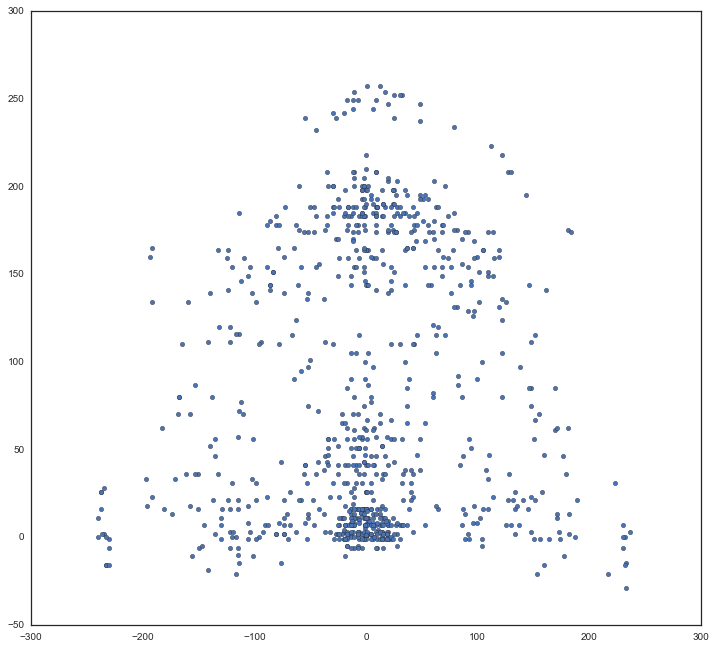

In [119]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(shot_df.LOC_X, shot_df.LOC_Y)
plt.show()

Please note that the above plot misrepresents the data. The x-axis values are the inverse 
of what they actually should be. Lets plot the shots taken from only the right side to see 
this issue.

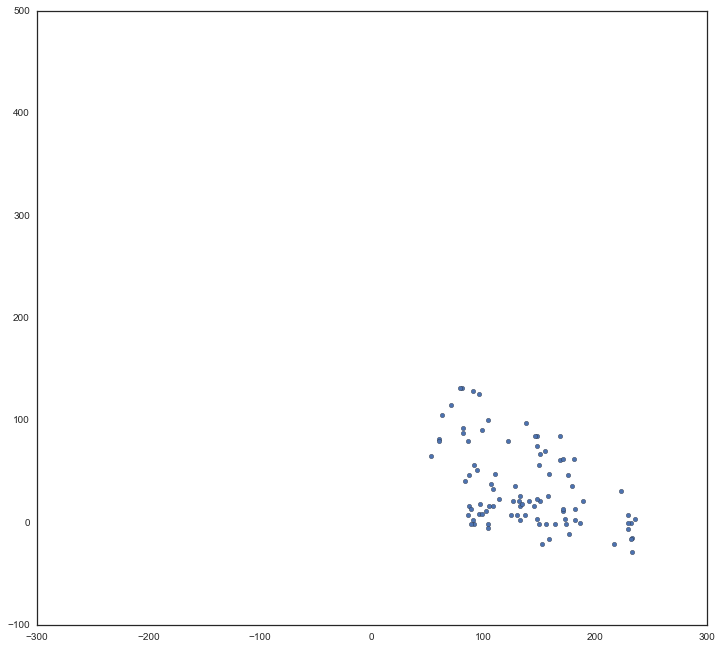

In [120]:
right = shot_df[shot_df.SHOT_ZONE_AREA == "Right Side(R)"]
plt.figure(figsize=(12,11))
plt.scatter(right.LOC_X, right.LOC_Y)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

As we can see the shots in categorized as shots from the "Right Side(R)", 
while to the viewers right, are actually to the left side of the hoop. 
This is something we will need to fix when creating our final shot chart.

### Drawing the Court ###

But first we need to figure out how to draw the court lines onto our plot. By looking at the first plot and 
at the data we can roughly estimate that the center of the hoop is at the origin. We can also estimate that 
every 10 units on either the x and y axes represents one foot. We can verify this by just look at the first
observation in our DataFrame . That shot was taken from the Right Corner 3 spot from a distance of 22 feet
with a LOC_X value of 226. So the shot was taken from about 22.6 feet to the right of the hoop. Now that we 
know this we can actually draw the court onto our plot.

The dimensions of a basketball court can be seen [here](http://www.sportscourtdimensions.com/wp- content/uploads/2015/02/nba_court_dimensions_h.png), and [here](http://www.sportsknowhow.com/basketball/dimensions/nba-basketball- court-dimensions.html).

Using those dimensions we can convert them to fit the scale of our plot and just draw them using 
[Matplotlib Patches](http://matplotlib.org/api/patches_api.html). We'll be using and [Arc](http://matplotlib.org/api/patches_api.html#matplotlib.patches.Arc) objects to draw our court. 

Now to create our function that draws our basketball court.

NOTE: While you can draw lines onto the plot using [Lines2D](http://matplotlib.org/api/lines_api.html? highlight=line#matplotlib.lines.Line2D) I found it more convenient to use Rectangles (without a height or width) instead.

EDIT (Aug 4, 2015): I made a mistake in drawing the outerlines and the half court arcs. The outer courtlines height was changed from the incorrect value of 442.5 to 470. The y-values for the centers of the center court arcs were changed from 395 to 422.5. The ylim values for the plots were changed from (395, -47.5) to (422.5, -47.5)

In [121]:
from matplotlib.patches import Circle, Rectangle, Arc
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    # Create the various parts of an NBA basketball court
    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
        linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
        linewidth=lw, color=color)
    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                       bottom_free_throw, restricted, corner_three_a,
                       corner_three_b, three_arc, center_outer_arc,
                       center_inner_arc]
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                 color=color, fill=False)
        court_elements.append(outer_lines)
        
        #Add the court elements onto the axes
        for element in court_elements:
            ax.add_patch(element)
        return ax


Lets draw our court

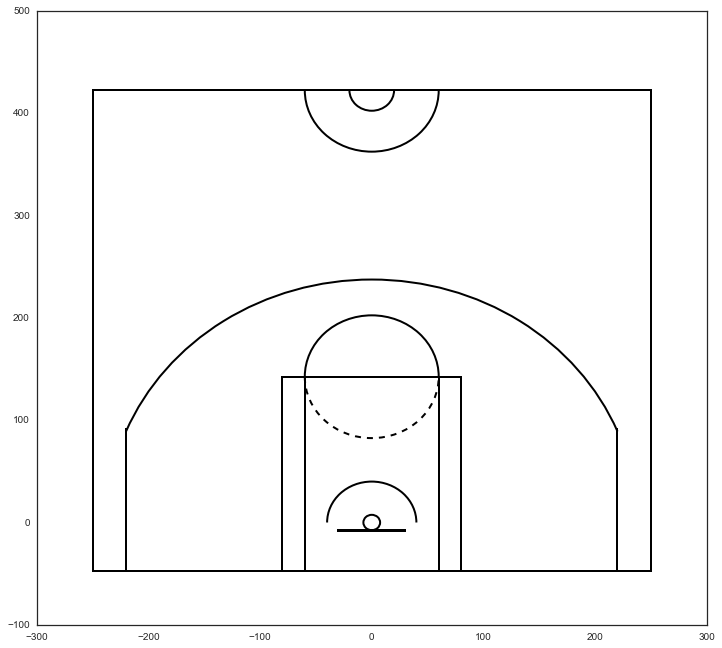

In [122]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

### Creating some Shot Charts ###
Now plot our properly adjusted shot chart data along with the court. We can adjust 
the x-values in two ways. We can either pass in the the negative inverse of LOC_X to 
plt.scatter or we can pass in descending values to plt.xlim . We'll do the latter to plot
our shot chart.

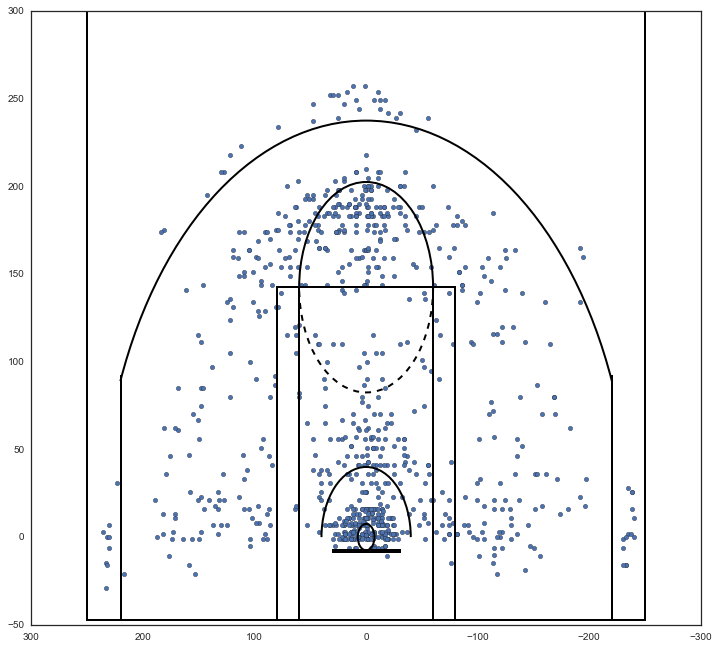

In [123]:
plt.figure(figsize=(12,11))
plt.scatter(shot_df.LOC_X, shot_df.LOC_Y)
draw_court(outer_lines=True)
# Descending values along the axis from left to right
plt.xlim(300,-300)
plt.show()

Lets orient our shot chart with the hoop by the top of the chart, which is the same orientation as the shot charts on stats.nba.com. We do this by settting descending y-values from the bottom to the top of the y-axis. When we do this we no longer need to adjust the x-values of our plot.

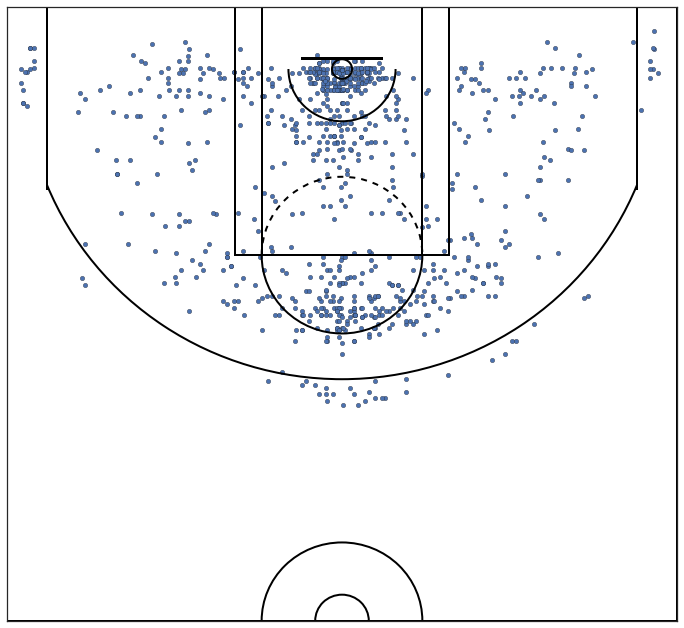

In [124]:
plt.figure(figsize=(12,11))
plt.scatter(shot_df.LOC_X, shot_df.LOC_Y)
draw_court(outer_lines=True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

Lets create a few shot charts using jointplot from seaborn .

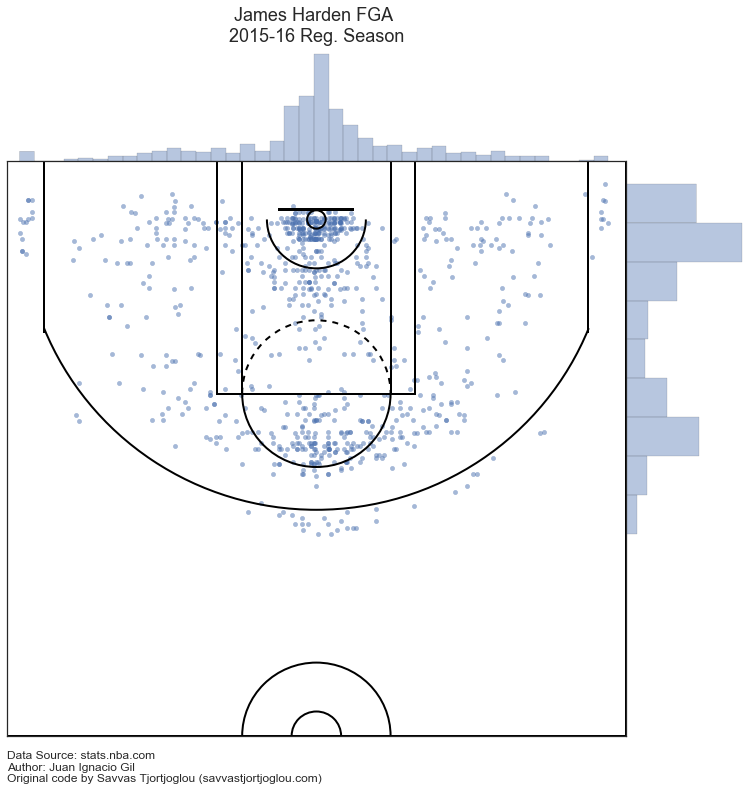

In [125]:
 # create our jointplot
joint_shot_chart = sns.jointplot(shot_df.LOC_X, shot_df.LOC_Y, 
                    stat_func=None,kind='scatter', space=0, alpha=0.5)
joint_shot_chart.fig.set_size_inches(12,11)
# A joint plot has 3 Axes, the first one called ax_joint
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax, outer_lines=True)
# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
# Add a title
ax.set_title('James Harden FGA \n2015-16 Reg. Season',
             y=1.2, fontsize=18)
# Add Data Scource and Author
authors="""Data Source: stats.nba.com
Author: Juan Ignacio Gil
Original code by Savvas Tjortjoglou (savvastjortjoglou.com)"""
        
ax.text(-250,460,authors,fontsize=12)
plt.show()

### Getting a Player's Image ###

We could also scrape Jame Harden's picture from stats.nba.com and place it on our plot. 
We can find his image at [this url](http://stats.nba.com/media/players/230x185/201935.png).
To retrieve the image for our plot we can use urlretrieve from url.requests as follows:

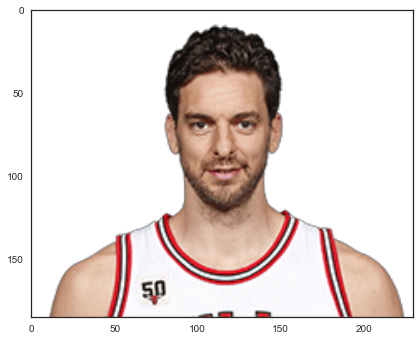

In [126]:
import urllib.request

# we pass in the link to the image as the 1st argument
# the 2nd argument tells urlretrieve what we want to scrape

pic = urllib.request.urlretrieve("http://stats.nba.com/media/players/230x185/"+playerID+".png",
                                 playerID+".png")

# urlretrieve returns a tuple with our image as the first
# element and imread reads in the image as a
# mutlidimensional numpy array so matplotlib can plot it
harden_pic = plt.imread(pic[0])
# plot the image
plt.imshow(harden_pic)
plt.show()

Now to plot Harden's face on a jointplot we will import OffsetImage from matplotlib. 
Offset, which will allow us to place the image at the top right corner of the plot. 
So lets create our shot chart like we did above, but this time we will create a [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) jointplot and at the end add 
on our image.

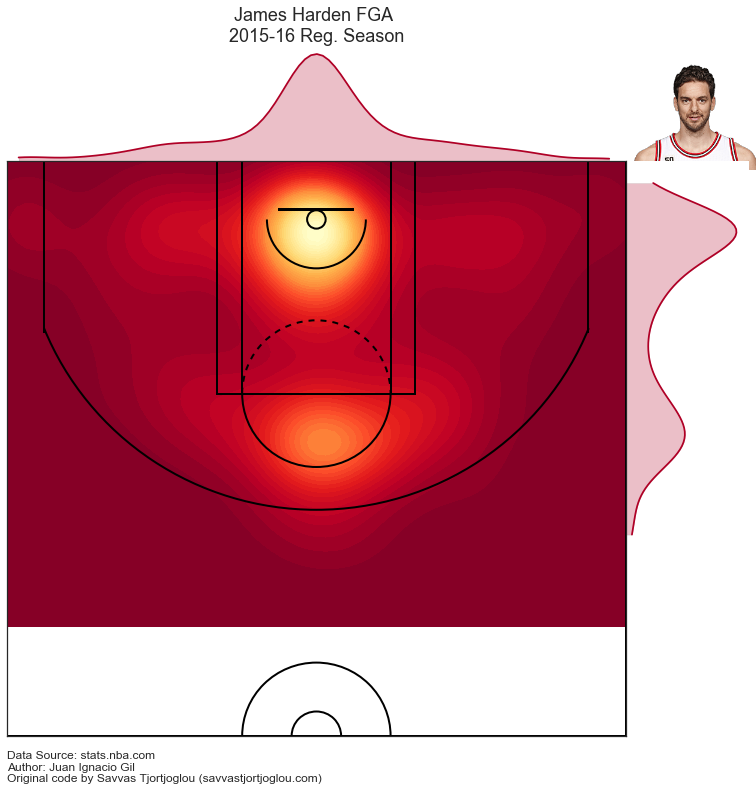

In [127]:
from matplotlib.offsetbox import  OffsetImage

# create our jointplot
# get our colormap for the main kde plot
# Note we can extract a color from cmap to use for
# the plots that lie on the side and top axes
cmap=plt.cm.YlOrRd_r

# n_levels sets the number of contour lines for the main kde plot
joint_shot_chart = sns.jointplot(shot_df.LOC_X, shot_df.LOC_Y, stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=50)
joint_shot_chart.fig.set_size_inches(12,11)
# A joint plot has 3 Axes, the first one called ax_joint
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax,outer_lines=True)
# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
# Add a title
ax.set_title('James Harden FGA \n2015-16 Reg. Season',
             y=1.2, fontsize=18)
# Add Data Scource and Author
ax.text(-250,460,authors,fontsize=12)
# Add Harden's image to the top right
# First create our OffSetImage by passing in our image
# and set the zoom level to make the image small enough
# to fit on our plot
img = OffsetImage(harden_pic, zoom=0.6)
# Pass in a tuple of x,y coordinates to set_offset
# to place the plot where you want, I just played around
# with the values until I found a spot where I wanted
# the image to be
img.set_offset((625,621))
# add the image
ax.add_artist(img)
plt.show()

And another jointplot but with hexbins.

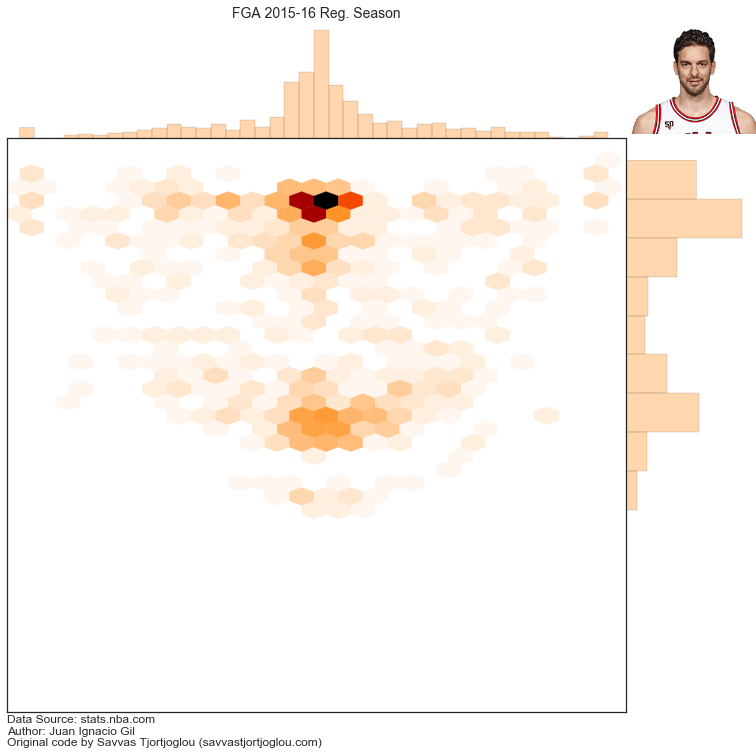

In [128]:
# create our jointplot

cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(shot_df.LOC_X, shot_df.LOC_Y, stat_func=None,
                                 kind='hex', space=0, color=cmap(.2), cmap=cmap)

joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto 
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('FGA 2015-16 Reg. Season', y=1.2, fontsize=14)

# Add Data Source and Author
ax.text(-250,450,authors, fontsize=12)

# Add James Harden's image to the top right
img = OffsetImage(harden_pic, zoom=0.6)
img.set_offset((625,621))
ax.add_artist(img)

plt.show()